# Explore measurements

Various diagnostic plots to explore our measurements.

In [1]:
%matplotlib inline
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns
from skimage import measure # to get contours from masks
import sklearn

import napari

sns.set_theme()

C:\ProgramData\Anaconda3\lib\site-packages\napari\_qt\__init__.py:37: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.9.7. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


In [2]:
os.chdir("D:/Hugo/Anaphase")
data = pd.read_csv("Analysis_BF_f0001-1-100.2.csv", sep=",", comment="#", index_col="idx")
data = data[data["time_to_anaphase"] >= 0].dropna()

# don't take the extremely long division processes into account 
data = data.drop(data[data.time_to_anaphase > 50].index)

print(data.shape)
data.head()

(475, 25)


,mom_ID,daugh_ID,frame,time,mom_x,mom_y,daugh_x,daugh_y,mom_surf,daugh_surf,...,daugh_ecc,mom_circ,daugh_circ,inter_centroid_dist,relat_inter_centroid_distance,anaphase,time_to_anaphase,movie_name,relat_circ,relat_ecc
idx,,,,,,,,,,,,,,,,,,,,,
0,7.0,5.0,0,0,341.034087,228.261538,332.043137,219.000000,178.867772,0.093045,...,0.992654,0.855372,0.785398,12.041595,0.343205,False,30,BF_f0001,0.918195,1.236316
0,7.0,5.0,1,6,341.018145,228.611940,330.688627,219.560000,186.583478,22.828404,...,0.898987,0.845002,0.857435,13.453624,0.287268,False,24,BF_f0001,1.014713,1.126581
0,7.0,5.0,2,12,337.864857,229.230769,326.733809,220.484848,177.583462,41.406857,...,0.937833,0.830149,0.864472,14.212670,0.284953,False,18,BF_f0001,1.041346,1.185947
0,7.0,5.0,3,18,338.649472,229.276923,326.261941,220.538462,177.867772,60.269635,...,0.875355,0.850590,0.878475,15.000000,0.279812,False,12,BF_f0001,1.032783,1.106011
0,7.0,5.0,4,24,339.320884,229.285714,326.185018,220.589744,172.867787,68.416707,...,0.859748,0.854060,0.887776,15.000000,0.273308,False,6,BF_f0001,1.039477,1.108345


# 1. Single feature exploration

No handles with labels found to put in legend.
No handles with labels found to put in legend.


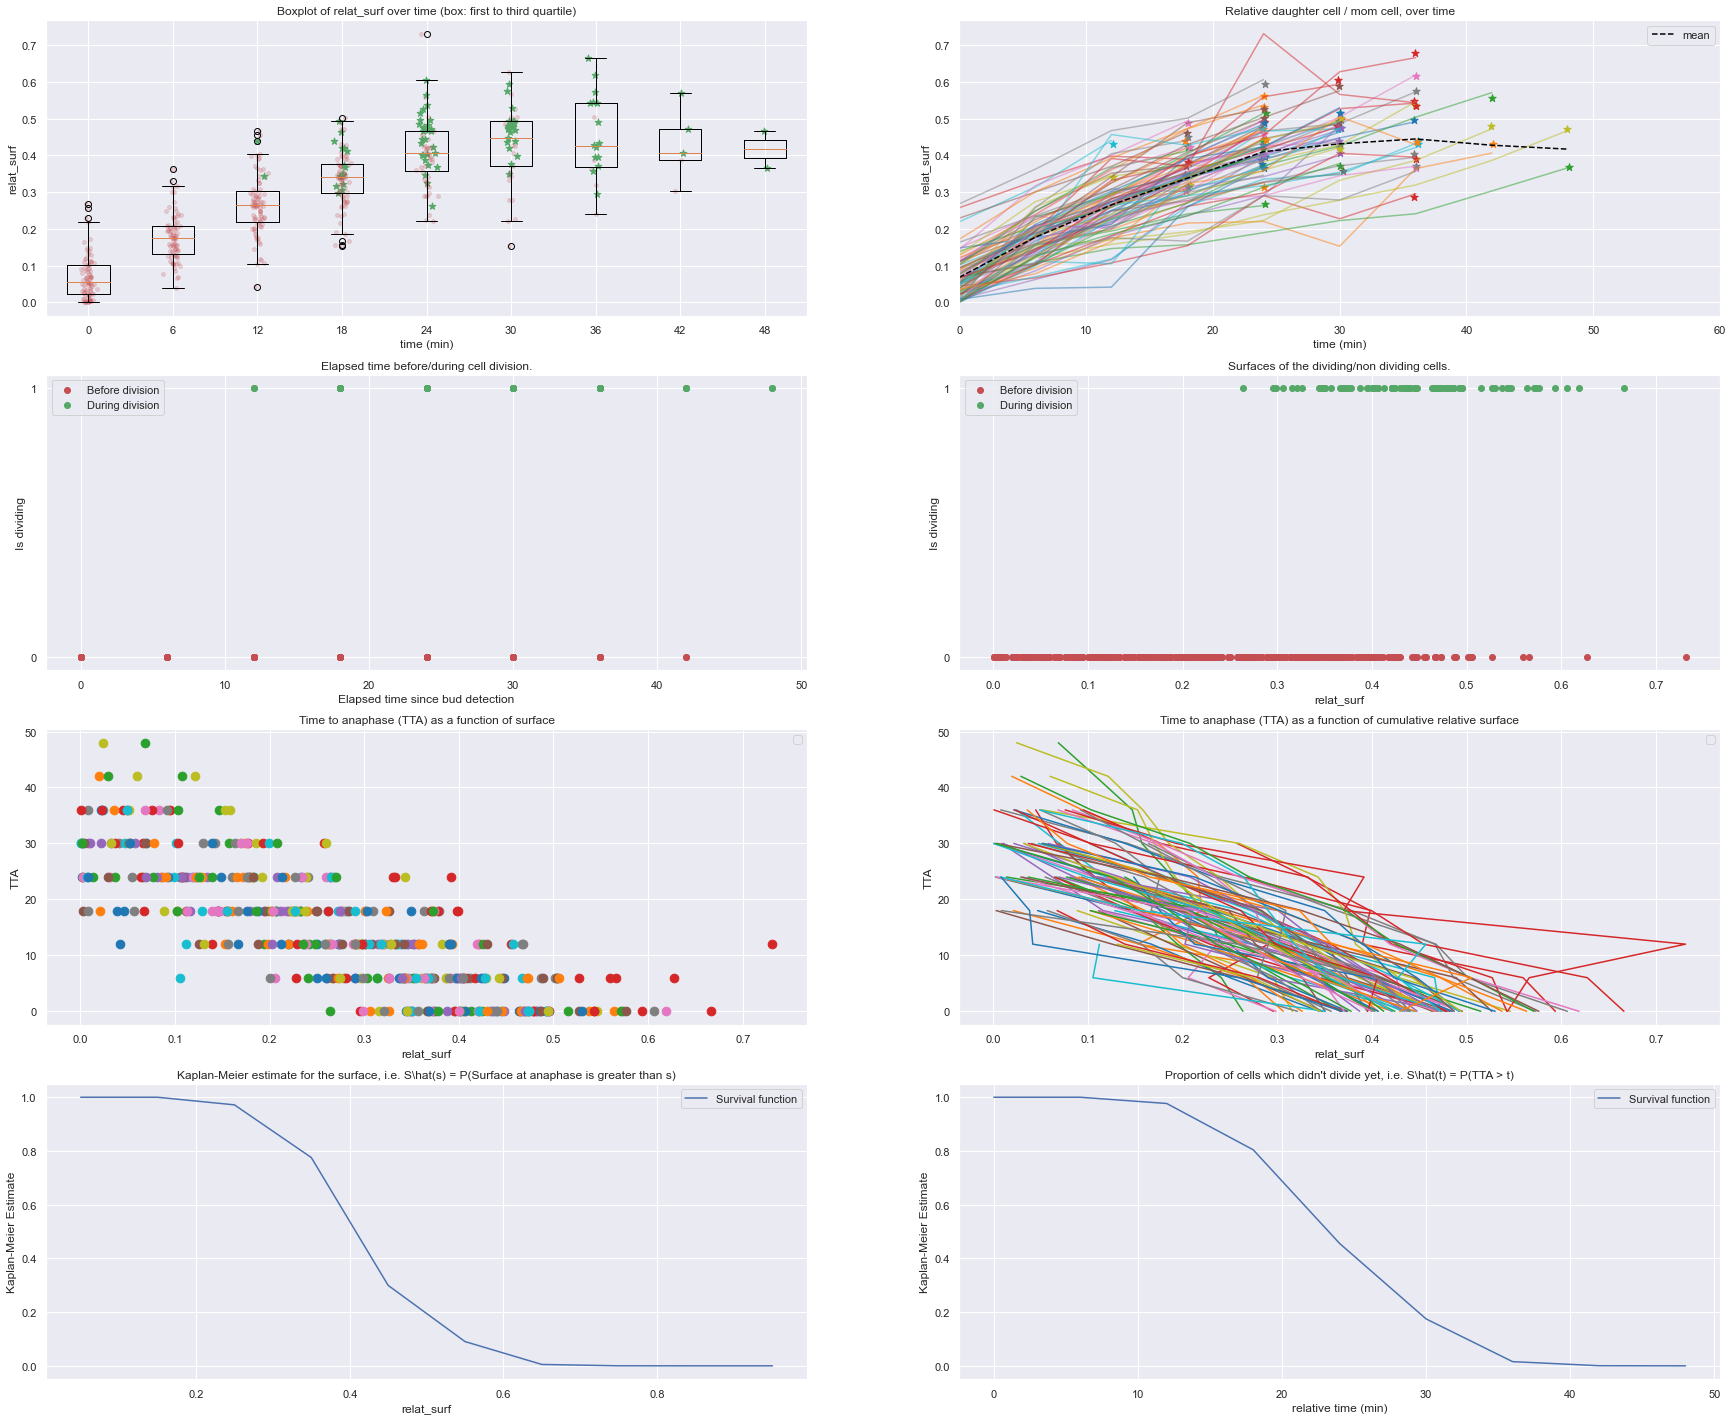

In [38]:
import matplotlib.colors as mcolors

# get matplotlib colors
by_hsv = [(tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                 name)
                for name, color in mcolors.TABLEAU_COLORS.items()]
names = [name for hsv, name in by_hsv]

fig, ax = plt.subplots(4, 2, figsize=(30, 25))

feature = "relat_surf"

# make boxplot on the first axis
vals, anaph, times, xs = [], [], [], []
for i, time in enumerate(data["time"].unique()):
    if time < 65: # do not append outliers
        d = data[data["time"] == time]
        vals.append(d[feature].values)
        anaph.append(d["anaphase"].values)
        times.append(str(time))
        xs.append(np.random.normal(i + 1, 0.04, d[feature].values.shape[0]))  # adds jitter to the data points - can be adjusted
    
ax[0][0].boxplot(vals, labels=times)
ax[0][0].set_ylabel(feature)
ax[0][0].set_title(f"Boxplot of {feature} over time (box: first to third quartile)")


for x, val, an, col in zip(xs, vals, anaph, names):  # add scatter plots to on the boxplots
    for jitter, v, a in zip(x, val, an):
        if a:
            ax[0][0].scatter(jitter, v, alpha=1, c="g", s=50, marker="*")
        else:
            ax[0][0].scatter(jitter, v, alpha=0.2, c="r", s=15)
    
ax[0][0].set_xlabel("time (min)")

# plot individual trajectories on the second axis
for idx in data.index.unique():
    event = data.loc[idx]
    
    # plot surface over time
#     if event[event["time"] == 6]["relat_surf"].values[0] > 0.2:
    ax[0][1].plot(event["time"], event[feature], c=names[idx % len(names)], alpha=0.5)

    # plot anaphase moment
    dx, dy = np.random.normal(0, 0.1, 1), np.random.normal(0, 0.01, 1)
    anaphase_moment = event[event["anaphase"]]
    ax[0][1].scatter(anaphase_moment["time"] + dx, anaphase_moment[feature] + dy, marker="*", s=60, c=names[idx % len(names)])
    
ax[0][1].plot(data["time"].unique(), data.groupby("time")[feature].mean(), "--", c="black", label="mean")

ax[0][1].legend()
ax[0][1].set_xlim(0, 60)
ax[0][1].set_xlabel("time (min)")
ax[0][1].set_ylabel(feature)
ax[0][1].set_title("Relative daughter cell / mom cell, over time")

# Conditional distributions on the third axis
will_divide = data[data["time_to_anaphase"] > 0]
is_dividing = data[data["time_to_anaphase"] == 0]

ax[1][0].scatter(will_divide["time"], [0 for i in range(will_divide["time"].shape[0])], c="r", label="Before division")
ax[1][0].scatter(is_dividing["time"], [1 for i in range(is_dividing["time"].shape[0])], c="g", label="During division")
ax[1][0].legend()
ax[1][0].set_xlabel("Elapsed time since bud detection")
ax[1][0].set_ylabel("Is dividing")
ax[1][0].set_yticks([0, 1])
ax[1][0].set_title("Elapsed time before/during cell division.")

# scatter plot on the fourth axis
ax[1][1].scatter(will_divide[feature], [0 for i in range(will_divide[feature].shape[0])], c="r", label="Before division")
ax[1][1].scatter(is_dividing[feature], [1 for i in range(is_dividing[feature].shape[0])], c="g", label="During division")
ax[1][1].legend()
ax[1][1].set_xlabel(feature)
ax[1][1].set_ylabel("Is dividing")
ax[1][1].set_yticks([0, 1])
ax[1][1].set_title("Surfaces of the dividing/non dividing cells.")

# Time-to-anaphase (TTA) as a function of the feature (relative surface)
for idx in data.index.unique():
    event = data.loc[idx]
    
    # plot surface over time
    ax[2][0].scatter(event[event["time_to_anaphase"] >= 0][feature], event[event["time_to_anaphase"] >= 0]["time_to_anaphase"], s=75, c=names[idx % len(names)], alpha=1)
    
ax[2][0].legend()
ax[2][0].set_xlabel(feature)
ax[2][0].set_ylabel("TTA")
ax[2][0].set_title("Time to anaphase (TTA) as a function of surface")

# plot TTA=f(cumulative surfaces) 
for idx in data.index.unique():
    event = data.loc[idx]
    
    # plot cumulative surface over time
    ax[2][1].plot(event[event["time_to_anaphase"] >= 0][feature], event[event["time_to_anaphase"] >= 0]["time_to_anaphase"], c=names[idx % len(names)], alpha=1)
    
ax[2][1].legend()
ax[2][1].set_xlabel(feature)
ax[2][1].set_ylabel("TTA")
ax[2][1].set_title("Time to anaphase (TTA) as a function of cumulative relative surface")

# plot TTA=f(cumulative surfaces) 
proportion_of_preevent = []
total_number_of_events = data.index.unique().shape[0]
step = 0.
while step < 0.9:
    at_this_surf = data[(step < data[feature]) & (data[feature] < step + 0.1)]
    pre_event, divided = at_this_surf[at_this_surf["time_to_anaphase"] > 0], at_this_surf[at_this_surf["time_to_anaphase"] <= 0]
    if pre_event.shape[0] == 0:
        proportion_of_preevent.append(0)
    else:
        proportion_of_preevent.append(pre_event.shape[0] / (pre_event.shape[0] + divided.shape[0]))  # proportion of cells which didn't divide yet
    step += 0.1
    
kaplan_meier_estimate = []
step = 0.
while step < 0.9:
    at_this_surf = data[(step < data[feature]) & (data[feature] < step + 0.1)]
    survived_and_didnt_divide, survived_and_divided = at_this_surf[at_this_surf["time_to_anaphase"] > 0], at_this_surf[at_this_surf["time_to_anaphase"] == 0]
    if survived_and_didnt_divide.shape[0] != 0:
        kaplan_meier_estimate.append(np.prod(kaplan_meier_estimate) * (1 - survived_and_divided.shape[0] / (survived_and_didnt_divide.shape[0] + survived_and_divided.shape[0])))  # proportion of cells which didn't divide yet
    else:
        kaplan_meier_estimate.append(0)
    step += 0.1    
    
ax[3][0].plot([0.1 * k + 0.05 for k in range(10)], kaplan_meier_estimate, label="Survival function")

ax[3][0].legend()
ax[3][0].set_xlabel(feature)
ax[3][0].set_ylabel("Kaplan-Meier Estimate")
ax[3][0].set_title("Kaplan-Meier estimate for the surface, i.e. S\hat(s) = P(Surface at anaphase is greater than s)")

# Survival time distribution estimation : P(S > t)_{t >= 0}
kaplan_meier_estimate = []
for t in data["time"].unique():
    at_this_time = data[data["time"] == t]
    survived_and_didnt_divide, survived_and_divided = at_this_time[at_this_time["time_to_anaphase"] > 0], at_this_time[at_this_time["time_to_anaphase"] == 0]
    if survived_and_didnt_divide.shape[0] != 0:
        kaplan_meier_estimate.append(np.prod(kaplan_meier_estimate) * (1 - survived_and_divided.shape[0] / (survived_and_didnt_divide.shape[0] + survived_and_divided.shape[0])))  # proportion of cells which didn't divide yet
    else:
        kaplan_meier_estimate.append(0)
    
ax[3][1].plot(data["time"].unique(), kaplan_meier_estimate, label="Survival function")

ax[3][1].legend()
ax[3][1].set_xlabel("relative time (min)")
ax[3][1].set_ylabel("Kaplan-Meier Estimate")
ax[3][1].set_title("Proportion of cells which didn't divide yet, i.e. S\hat(t) = P(TTA > t)")

save_fig = False
if save_fig:
    plt.savefig("Description_BF_f0001_division_events.pdf", format="pdf")

# 2. Correlations between features

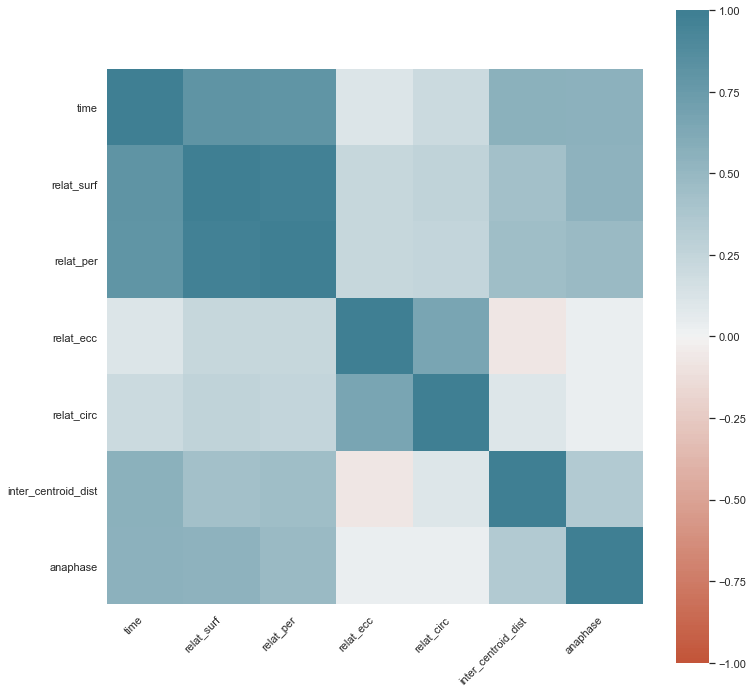

In [44]:
# features
features = ["time",
            "relat_surf",
            "relat_per",
            "relat_ecc",
            "relat_circ",
            "inter_centroid_dist",
            "anaphase",
           ]

df = data[features]


heatmap = True
if heatmap:
    corr = df.corr(method="pearson")
    corr.style.background_gradient(cmap='coolwarm') # This line plots nicely visualized matrix of correlation
    fig, ax = plt.subplots(1, 1,figsize=(12, 12))
    sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

pairplot = False
if pairplot:
    ax = sns.pairplot(df, hue="anaphase")

save_fig = False
if save_fig:
    plt.savefig("heatmap_relative_features.png", format="png")